# Image classification with convolutional neural networks

In this script we create, train, and evaluate an image classifier based on convolutional neural networks (CNNs).

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import copy

In [2]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02, generator=torch.manual_seed(seed))
        m.bias.data.fill_(0.01)
    return

## Dataset

In this lab we work with the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset: it's similar to MNIST, but these are images of clothes from Zalando instead of digits.

<center><a href="https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5">
    <img src="https://miro.medium.com/max/1400/1*jXssb_WjoYZgepOCfdQfJA.png" width="400"></a></center>

Like MNIST, each image comes with a label between 0 and 9 (10 classes). The mapping between integer labels and actual classes (0 = t-shirt, 1 = trousers, etc.) can be found [here](https://github.com/zalandoresearch/fashion-mnist#labels).

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [14]:
# Chemins des répertoires train et test
train_dir = '../datasets/chihuahua/train'
test_dir = '../datasets/chihuahua/test'

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transformations appliquées aux images (ex: redimensionnement, normalisation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize les images à 224x224 pixels
    transforms.ToTensor(),          # Convertir l'image en tenseur
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalisation
])

# Charger le dataset d'entraînement complet
train_data = datasets.ImageFolder(root=train_dir, transform=transform)

# Définir les proportions pour l'entraînement et la validation
train_size = int(0.8 * len(train_data))  # 80% pour l'entraînement
valid_size = len(train_data) - train_size  # 20% pour la validation

# Diviser le dataset d'entraînement en entraînement et validation
train_data, valid_data = random_split(train_data, [train_size, valid_size])

# Charger le dataset de test
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# Définir la taille des batches
batch_size = 32

# Créer les DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Vérification des tailles
print(f"Taille du train_loader: {len(train_loader.dataset)} images")
print(f"Taille du valid_loader: {len(valid_loader.dataset)} images")
print(f"Taille du test_loader: {len(test_loader.dataset)} images")



Taille du train_loader: 3786 images
Taille du valid_loader: 947 images
Taille du test_loader: 1184 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow 

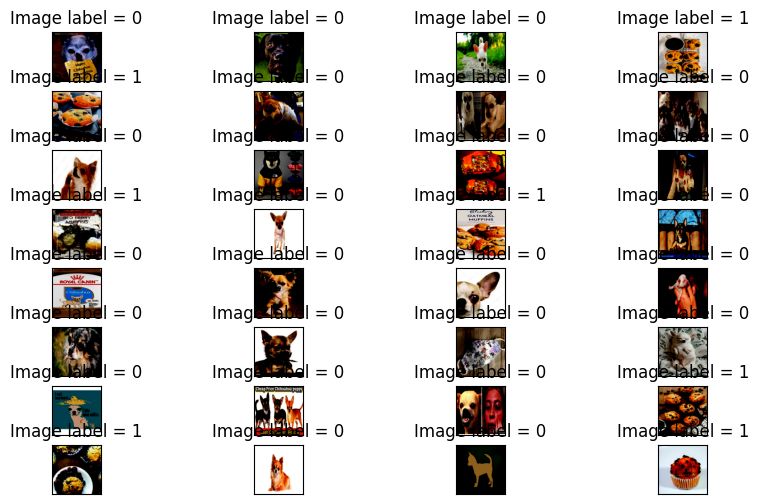

In [15]:
# Get a batch of images from the train dataloader and print it
image_batch_example, labels_batch_example = next(iter(train_loader))

plt.figure(figsize=(10, 6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib + 1)
    
    image = image_batch_example[ib].permute(1, 2, 0).detach().numpy()

    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
    
plt.show()

## CNN classifier

A CNN classifier usually consists of:
- one or several convolutional layers/modules that produce intermediate latent representations called ***feature maps***
- an output linear layer performing classification from the feature maps

<center><a href="https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac">
    <img src="https://miro.medium.com/max/700/1*LTRcAyl6zuuJvpU-5KECZA.png"></a></center>

### Example

In [16]:
# Let us create a first CNN layer, with:
# - a convolution function, with 16 output channels, kernel_size=5, padding=2, and bias
# - a non-linear activation function (ReLU)
# - a max pooling function

cnn_layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out1 = cnn_layer1(image_batch_example)
print(out1.shape)

torch.Size([32, 16, 112, 112])


In [17]:
# TO DO: create the second CNN layer, with the same structure as the first one
# (same non-linear activation and max pooling functions), but the convolution function
# now has 16 input channels and 32 output channels
# After creating it, apply it to 'out1' to compute out2, and print the shape of out2.
cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out2 = cnn_layer2(out1)
print(out2.shape)

torch.Size([32, 32, 56, 56])


In [18]:
# Now, we define a linear layer to perform classification (as in Lab 3)

# First, we need to flatten out2, since linear layers in pytorch process vectors (or more precisely batches of vectors)
# The resulting vector should have a shape = (batch_size, 32 x 7 x 7)
num_classes = 2
out_vec = out2.reshape(out2.shape[0], -1)
print(out_vec.shape)

# TO DO: define a Linear layer with appropriate parameters
# - the input size is given by checking the shape of 'out_vec'
input_size_linear = out_vec.shape[-1]
# - the output size is the number of classes in the dataset
# Once defined, apply this layer to out_vec
cnn_layer3 = nn.Sequential(nn.Linear(input_size_linear, num_classes), nn.ReLU())
out3 = cnn_layer3(out_vec)
print(out3.shape)

torch.Size([32, 100352])
torch.Size([32, 2])


### General module

Now, let's create a general CNN classification network, train and test it. The CNN module takes as inputs the number of output channels in each layer (and the number of classes), but we also have to explicitly provide the input size of the Linear layer, since it depends on many other parameters (image size, but also kernel, padding, stride, number of channels in the convolutions...). Instead of computing it with a general (and heavy) formula, it's easier to just get it from an example (as above), and then pass it as an input parameter.

**Note**: there are ways to alleviate this issue (e.g., using another convolution layer with as many kernels as output classes, and then global pooling)... but that's outside the scope of these labs.

In [24]:
# TO DO: Define the CNN classifier module ('__init__' and 'forward' methods).
# It's architecture is the same as in the example above.

class CNNClassif(nn.Module):
    def __init__(self, input_size_linear, num_channels1=16, num_channels2=32, num_classes=2):
        super().__init__()
        self.input = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.hidden = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.output = nn.Sequential(nn.Linear(input_size_linear, num_classes), nn.ReLU())
        pass 
       
    def forward(self, x):
        out1 = self.input(x)
        out2 = self.hidden(out1)
        out3 = self.output(out2.reshape(out2.shape[0], -1))
        return out3

In [25]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 10
model = CNNClassif(input_size_linear, num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# initialization of the network's parameters
model.apply(init_params)

Total number of parameters:  1017578


CNNClassif(
  (input): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output): Sequential(
    (0): Linear(in_features=100352, out_features=10, bias=True)
    (1): ReLU()
  )
)

## Training and evaluation

The evaluation and training function (with validation) are almost the same as in lab4.1, except we don't need to vectorize the images. Indeed, MLPs process (batches of) vectors, while CNNs directly process (batches of) images.

In [28]:
# TO DO: write the evaluation and training function with validation.

def eval_cnn_classifier(model, eval_dataloader):
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            #images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

def train_val_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True, seed=0):
    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list for storing the training loss over epochs
    train_losses = []

    best_model = (copy.deepcopy(model_tr), 0)
    val_accuracy = []
    
    # Training loop
    for epoch in range(num_epochs):
        
        # Initialize the training loss for the current epoch
        tr_loss = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            #img_vectorize = images.view(images.shape[0], 1*28*28)
            y_pred = model_tr.forward(images)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
           
            # For each batch, we update the current epoch loss
            tr_loss += loss.item()  
        


        # At the end of each epoch, get the average training loss over all batches
        tr_loss = tr_loss / len(train_dataloader)
        train_losses.append(tr_loss)

        accuracy = eval_cnn_classifier(model_tr,valid_dataloader)
        if accuracy > best_model[1]:
            best_model = (copy.deepcopy(model_tr), accuracy)
            
        val_accuracy.append(accuracy)
        
        # Display the training loss
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}, Accuracy : {:.4f}'.format(epoch+1, num_epochs, tr_loss, accuracy))

    
    return best_model, train_losses, val_accuracy

In [29]:
# Optimizer
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model_tr, train_losses, val_accuracies = train_val_cnn_classifier(model, train_loader, valid_loader, num_epochs, loss_fn, learning_rate, verbose=True)

# Display the training loss and validation accuracy over epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(torch.arange(num_epochs)+1, train_losses)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(torch.arange(num_epochs)+1, val_accuracies)
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.show()

Epoch [1/40], Training loss: 0.5749, Accuracy : 82.6822
Epoch [2/40], Training loss: 0.3154, Accuracy : 85.5333
Epoch [3/40], Training loss: 0.2184, Accuracy : 87.8564
Epoch [4/40], Training loss: 0.1364, Accuracy : 86.2724


KeyboardInterrupt: 

In [13]:
# TO DO: Compute the test accuracy
accuracy = eval_cnn_classifier(model_tr[0], valid_loader)
accuracy

48.0

<span style="color:red">**Q3**</span> What is the test accuracy?

## Batch normalization

When passing images to a CNN, each image might have different distribution / statistics. This causes the gradient at each batch to change a lot, and this makes the stochastic gradient descent algorithm quite unstable.

To prevent from this problem, we use **batch normalization**, which basically normalizes each batch of data to a given mean / standard deviation. This makes training more stable, and usually significantly faster.

Batch norm is easy to write in Pytorch (see the [doc](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d)).

**Note**: batch normalization should be only used for training, but should be disabled when testing the model. That's why we set `model.eval()` in the evaluation function.

In [14]:
# TO DO : rewrite the CNNClassif module, but insert BatchNorm2D in each CNN layer, between RELU and Maxpooling.

class CNNClassif_bnorm(nn.Module):
    def __init__(self, input_size_linear, num_channels1=16, num_channels2=32, num_classes=10):
        super().__init__()
        self.input = nn.Sequential(nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),nn.ReLU(),nn.BatchNorm2d(16), nn.MaxPool2d(kernel_size=2))
        self.hidden = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.output = nn.Sequential(nn.Linear(input_size_linear, num_classes), nn.ReLU())
        pass
   
    def forward(self, x):
        
        out1 = self.input(x)
        out2 = self.hidden(out1)
        out3 = self.output(out2.reshape(out2.shape[0], -1))
        return out3        

Total number of parameters:  28938
Epoch [1/40], Training loss: 1.8119
Epoch [2/40], Training loss: 1.5352
Epoch [3/40], Training loss: 1.4209
Epoch [4/40], Training loss: 1.3628
Epoch [5/40], Training loss: 1.3183
Epoch [6/40], Training loss: 1.2798
Epoch [7/40], Training loss: 1.3028
Epoch [8/40], Training loss: 1.2621
Epoch [9/40], Training loss: 1.2388
Epoch [10/40], Training loss: 1.2283
Epoch [11/40], Training loss: 1.2257
Epoch [12/40], Training loss: 1.2138
Epoch [13/40], Training loss: 1.2106
Epoch [14/40], Training loss: 1.2095
Epoch [15/40], Training loss: 1.2086
Epoch [16/40], Training loss: 1.2085
Epoch [17/40], Training loss: 1.2073
Epoch [18/40], Training loss: 1.2053
Epoch [19/40], Training loss: 1.2053
Epoch [20/40], Training loss: 1.2049
Epoch [21/40], Training loss: 1.2047
Epoch [22/40], Training loss: 1.2045
Epoch [23/40], Training loss: 1.2057
Epoch [24/40], Training loss: 1.2044
Epoch [25/40], Training loss: 1.2055
Epoch [26/40], Training loss: 1.2044
Epoch [27/40

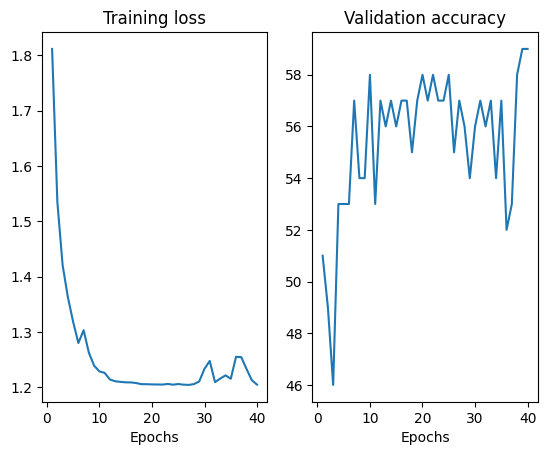

In [15]:
# TO DO:
# - instantiate the model and initialize its parameters
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 10
model_bn = CNNClassif_bnorm(input_size_linear, num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# initialization of the network's parameters
model_bn.apply(init_params)
# - train it, and plot the training and validation losses
# Optimizer
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model_tr, train_losses_bn, val_accuracies_bn = train_val_cnn_classifier(model_bn, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)
# - compute and print the test accuracy
# Display the training loss and validation accuracy over epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(torch.arange(num_epochs)+1, train_losses_bn)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(torch.arange(num_epochs)+1, val_accuracies_bn)
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.show()

In [17]:
accuracy = eval_cnn_classifier(model_tr[0], valid_dataloader)
accuracy

59.0

<span style="color:red">**Q4**</span> In your report, provide the test accuracy of the network with batch norm. Also plot the training loss and validation accuracy (both with and without batch norm). What do you conclude?

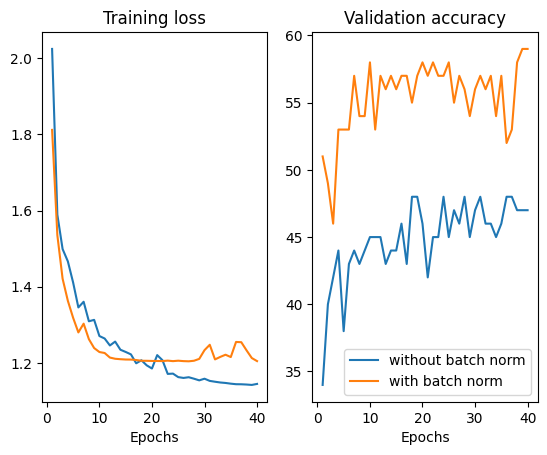

In [18]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(torch.arange(num_epochs)+1, train_losses, label='without batch norm')
plt.plot(torch.arange(num_epochs)+1, train_losses_bn, label='with batch norm')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(torch.arange(num_epochs)+1, val_accuracies, label='without batch norm')
plt.plot(torch.arange(num_epochs)+1, val_accuracies_bn, label='with batch norm')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()